# Chapter 3: Your First GAN　初めてのGAN

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# モデルの入力宣言

img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions （入力画像の次元）
img_shape = (img_rows, img_cols, channels)  #(28, 28, 1)

# Size of the noise vector, used as input to the Generator（生成器の入力ノイズベクトルの次元）
z_dim = 100

## Generator（生成器）

In [3]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Fully connected layer   input_shape =(100,) == input_dim = 100
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))

    return model

## Discriminator（識別器）

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))

    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

## Build the Model(GANの構築とコンパイル)

In [5]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Training　訓練

In [7]:
#Data size チェック

(X_train, _), (_, _) = mnist.load_data()

    
X_train = X_train / 127.5 - 1.0
print(X_train.shape)

X_train = np.expand_dims(X_train, axis=3)  # (6028, 28, 1)
print(X_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [8]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0                       # (6000, 28, 28)
    X_train = np.expand_dims(X_train, axis=3)             # (6000, 28, 28, 1)

    # Labels for real images: all ones(本物の画像のラベルは全て１とする)
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros(偽の画像のラベルは全て０とする)
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator　識別器の訓練
        # -------------------------

        # Get a random batch of real images（本物の画像をランダムに取り出したバッチを作る）
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [9]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Train the GAN and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

1000 [D loss: 0.182320, acc.: 92.97%] [G loss: 3.733056]
2000 [D loss: 0.048376, acc.: 98.05%] [G loss: 6.488160]
3000 [D loss: 0.082229, acc.: 97.27%] [G loss: 5.056893]
4000 [D loss: 0.225318, acc.: 91.80%] [G loss: 4.028664]
5000 [D loss: 0.161198, acc.: 93.36%] [G loss: 4.458834]
6000 [D loss: 0.273181, acc.: 89.45%] [G loss: 4.320057]
7000 [D loss: 0.195883, acc.: 93.75%] [G loss: 3.865498]
8000 [D loss: 0.378571, acc.: 84.38%] [G loss: 3.450563]
9000 [D loss: 0.678991, acc.: 71.09%] [G loss: 2.365891]
10000 [D loss: 0.261749, acc.: 88.28%] [G loss: 2.934107]
11000 [D loss: 0.260119, acc.: 89.84%] [G loss: 3.255094]
12000 [D loss: 0.424551, acc.: 80.86%] [G loss: 2.359533]
13000 [D loss: 0.549934, acc.: 76.95%] [G loss: 2.247837]
14000 [D loss: 0.352377, acc.: 84.38%] [G loss: 2.404661]
15000 [D loss: 0.492821, acc.: 78.12%] [G loss: 2.398686]
16000 [D loss: 0.305562, acc.: 85.55%] [G loss: 2.654949]
17000 [D loss: 0.283999, acc.: 88.67%] [G loss: 3.108624]
18000 [D loss: 0.256300

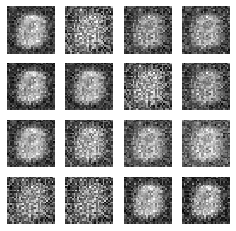

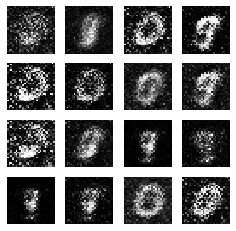

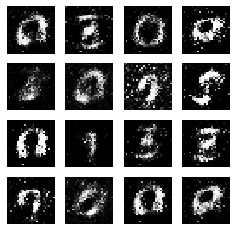

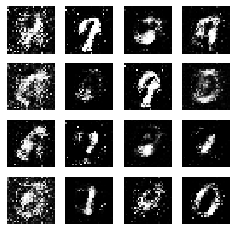

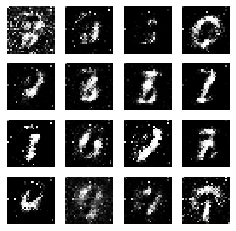

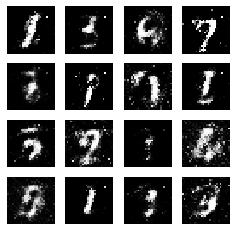

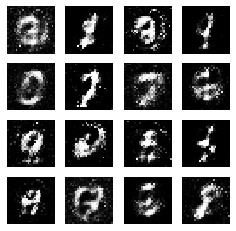

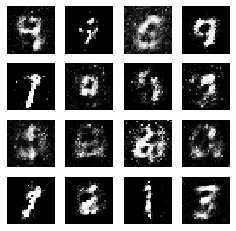

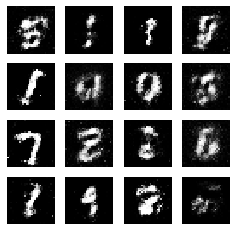

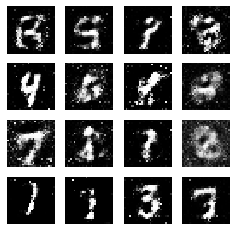

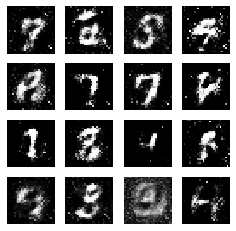

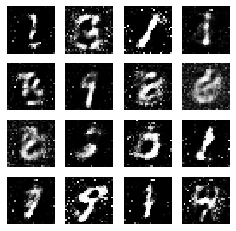

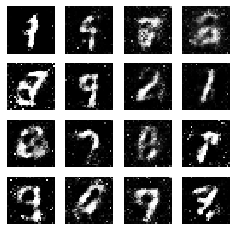

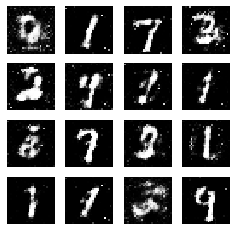

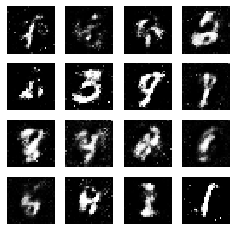

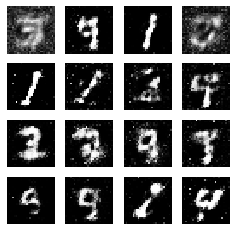

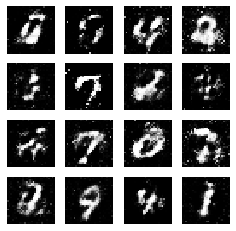

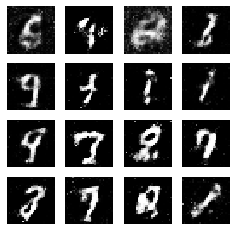

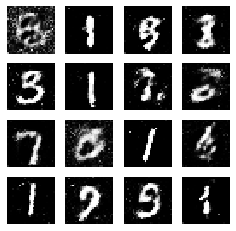

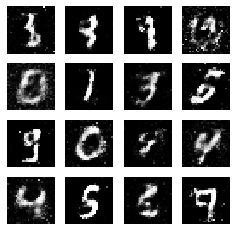

In [10]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

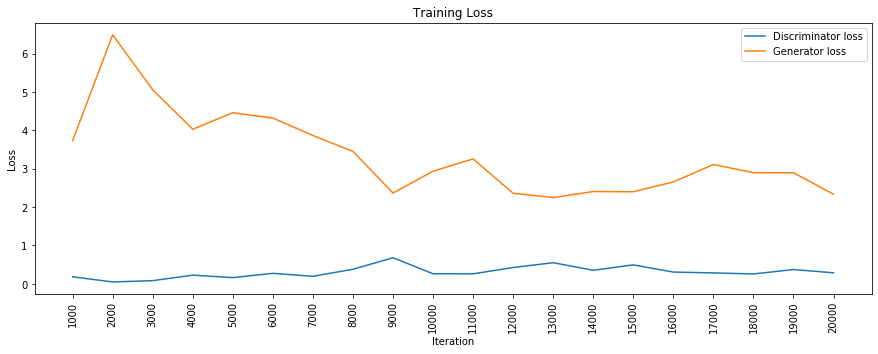

In [11]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

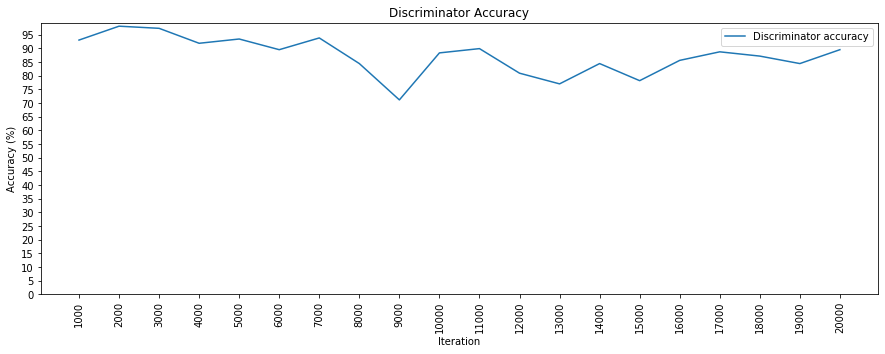

In [12]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

----